In [1]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import h5py 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from AEDataset import AEDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
from AE import AE
from sklearn.metrics import r2_score
import similarities

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LINCS Valuation 

Train - All samples without an APC value or with an APC value less than 0.7. 
Valid - 75% of samples with an APC value >= 0.7 
Test - 25% of samples with an APC value >= 0.7

In this approach, we explore how data valuation can be used in unsupervised settings. To do this we will be using drug perturbed cancer cell line gene expression from the LINCS project. Data quality in this project is notoriously variable due to batch effects and biological variability; one sample level quality metric that has shown promise is the Average Pearson Correlation (APC) of bio-replicates. We will use this metric to create a 'high quality' validation and test dataset, and use it as baseline to compare against. 

We will use 978 "landmark" genes expression in a auto-encoder architecture, with the assumption that higher quality data is more likely to have latent variables that can be captured in a reduced representation, e.g., noise won't compress. 

To evaluate the usefulness of this, we will iteratively remove subsets of low/high data values and evaluate autoencoder performance on a hold-out high-quality test datatset. For baseline, we will compare against APC values, where NA values will be median-imputed. 


# Missing rAPC ids 

For some reason there are ~500 missing ids from `rAPC.csv`; has something to do with NAN `pert_dose` 

In [2]:
x_train = torch.load('../data/lincs/l1000_data_TRAIN.pt')
x_valid = torch.load('../data/lincs/l1000_data_VALID.pt')

In [3]:
train_dataset = AEDataset(x_train)
valid_dataset = AEDataset(x_valid)

In [4]:
model = AE(in_channels=978, latent_channels=64, norm=False, dropout=0.25, bias=True, act=torch.nn.Mish, num_layers=1)
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
#dvgs.pretrain_(crit=torch.nn.MSELoss(), num_workers=5, batch_size=512, lr=1e-3, epochs=1, use_cuda=True, verbose=True, report_metric=lambda x,y: r2_score(x,y, multioutput='uniform_average'))

In [5]:
_ = [print(f'"{n}",',end='') for n,p in model.named_parameters()]

"encoder.f.0.weight","encoder.f.0.bias","encoder.f.4.weight","encoder.f.4.bias","decoder.f.0.weight","decoder.f.0.bias","decoder.f.4.weight","decoder.f.4.bias",

In [8]:
# this should take around 11 hours 

tic = time.time() 
run_id = dvgs.run(crit                  = torch.nn.MSELoss(), 
                  save_dir              = '../lincs_results/',
                  similarity            = similarities.cosine_similarity(), 
                  optim                 = torch.optim.Adam, 
                  lr                    = 1e-3, 
                  num_epochs            = 10, 
                  compute_every         = 1, 
                  target_batch_size     = 2000, 
                  source_batch_size     = 256, 
                  num_workers           = 1, 
                  grad_params           = None, 
                  verbose               = True, 
                  use_cuda              = True)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

source gradient calculations will use randomness="same" instead of "different" as it with GPU.
using device: cpu


KeyboardInterrupt: 

In [12]:
apc2 = apc[lambda x: x.train].assign(vals = vals_dvgs.mean(axis=1))
apc2.head()

,sample_id,APC,nrepl,L1,L2,train,valid,vals
0,ABY001_A375_XH_X1_B15:A13,0.324414,8.0,1.649418,11.675443,True,False,0.029520
1,ABY001_A375_XH_X1_B15:A14,0.189060,10.0,1.265392,4.093121,True,False,0.008067
2,ABY001_A375_XH_X1_B15:A15,0.436836,9.0,2.257690,11.702172,True,False,0.024970
3,ABY001_A375_XH_X1_B15:A16,0.089820,8.0,0.961196,2.485945,True,False,0.006870
4,ABY001_A375_XH_X1_B15:A17,0.367309,8.0,1.855790,9.666554,True,False,0.058801


In [13]:
apc2[lambda x: x.APC != -666][['APC','vals']].corr('pearson')

,APC,vals
APC,1.000000,0.567863
vals,0.567863,1.000000


In [14]:
apc2[lambda x: x.APC != -666][['APC','vals']].corr('spearman')

,APC,vals
APC,1.000000,0.199434
vals,0.199434,1.000000


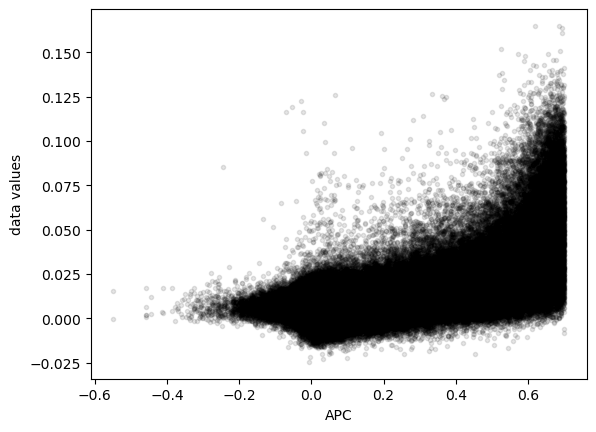

In [15]:
plt.figure()
plt.plot(apc2[lambda x: x.APC != -666].APC.values, apc2[lambda x: x.APC != -666].vals.values, 'k.', alpha=0.1)
plt.xlabel('APC')
plt.ylabel('data values')
plt.show()

In [27]:
apc2.head()

,sample_id,APC,nrepl,L1,L2,train,valid,vals
0,ABY001_A375_XH_X1_B15:A13,0.324414,8.0,1.649418,11.675443,True,False,0.095473
1,ABY001_A375_XH_X1_B15:A14,0.189060,10.0,1.265392,4.093121,True,False,0.080264
2,ABY001_A375_XH_X1_B15:A15,0.436836,9.0,2.257690,11.702172,True,False,0.089090
3,ABY001_A375_XH_X1_B15:A16,0.089820,8.0,0.961196,2.485945,True,False,0.056643
4,ABY001_A375_XH_X1_B15:A17,0.367309,8.0,1.855790,9.666554,True,False,0.046387


In [29]:
top80_idx = (apc2.vals >= apc2.vals.quantile(0.2)).values.nonzero()[0]

In [31]:
top80_train = l1000[train_idx, :][top80_idx, :]

: 

: 

In [ ]:
top80_train_dataset = AEDataset(top80_train)

/home/teddy/local/DVGS/manuscript_notebooks/../src/AEDataset.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [ ]:
model2 = AE(in_channels=978, latent_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, num_layers=1)
dvgs2 = DVGS(top80_train_dataset, valid_dataset=None, test_dataset=None, model=model)
dvgs2.pretrain_(crit=torch.nn.MSELoss(), num_workers=5, batch_size=512, lr=1e-3, epochs=3, use_cuda=True, verbose=True, report_metric=lambda x,y: r2_score(x,y, multioutput='uniform_average'))

using device: cuda

epoch: 0 | loss: 4.4388 | metric: 0.1074
epoch: 1 | loss: 4.4395 | metric: 0.1069
